## Factor Discovery

## Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
gsw = pd.read_excel('data/gsw_yields.xlsx', index_col=0, parse_dates=True)

maturities = [2,5,10]
yields = gsw[maturities].dropna()
yields.columns = ['2Y','5Y','10Y']

yields = yields.loc['2015':]

print(f"Date range: {yields.index.min().date()} to {yields.index.max().date()}")
print(f"Observations: {len(yields)}")
yields.tail()

Date range: 2015-01-02 to 2025-12-26
Observations: 2747


,2Y,5Y,10Y
Date,,,
2025-12-19,3.4741,3.6742,4.2367
2025-12-22,3.4956,3.6938,4.2475
2025-12-23,3.5287,3.7140,4.2410
2025-12-24,3.5278,3.7004,4.2158
2025-12-26,3.4816,3.6707,4.2193


### a. Compute daily yield changes for 2Y, 5Y, and 10Y maturities. Standardize the changes before running PCA.

In [3]:
from sklearn.preprocessing import StandardScaler

yields_diff = yields.diff(periods=1).dropna()
yields_diff.tail()


scaler = StandardScaler()
yields_diff_scaled = scaler.fit_transform(yields_diff)

yields_diff_scaled[:5]

array([[ 0.05797972, -0.9102962 , -1.65108311],
       [-0.60854424, -1.23660472, -1.24215484],
       [-0.38369154, -0.36887606, -0.11394598],
       [-0.40778316,  0.51525321,  1.19499707],
       [-0.48808855, -1.02514178, -0.84782929]])

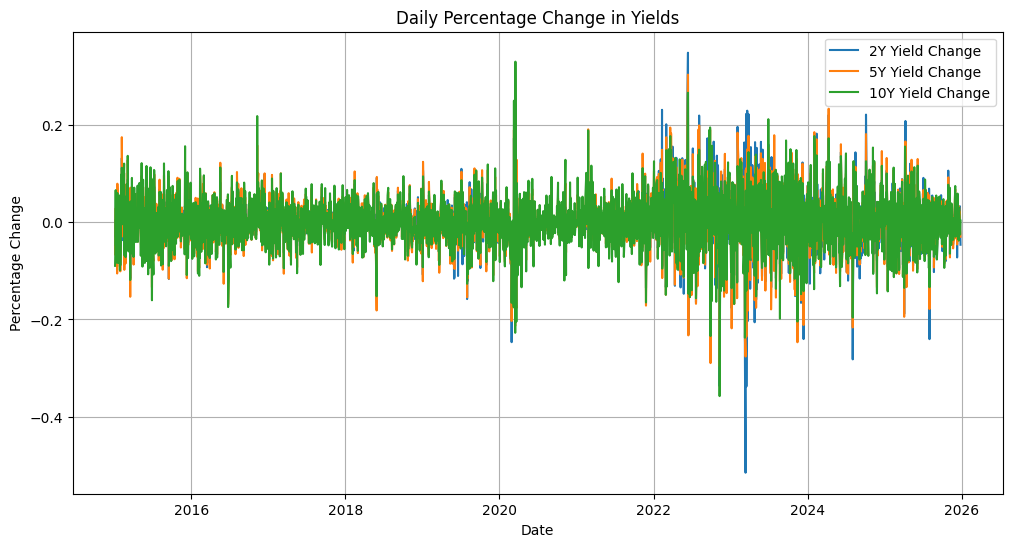

In [4]:
plt.figure(figsize=(12,6))
plt.plot(yields_diff.index, yields_diff['2Y'], label='2Y Yield Change')
plt.plot(yields_diff.index, yields_diff['5Y'], label='5Y Yield Change')
plt.plot(yields_diff.index, yields_diff['10Y'], label='10Y Yield Change')
plt.title('Daily Percentage Change in Yields')
plt.xlabel('Date')
plt.ylabel('Percentage Change')
plt.legend()
plt.grid()
plt.show()

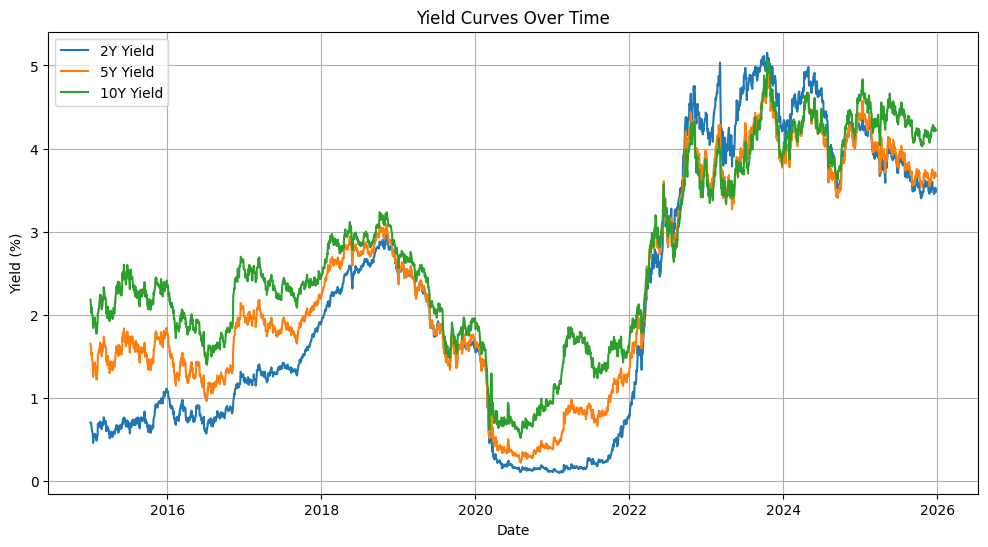

In [5]:
plt.figure(figsize=(12,6))
plt.plot(yields.index, yields['2Y'], label='2Y Yield') 
plt.plot(yields.index, yields['5Y'], label='5Y Yield')
plt.plot(yields.index, yields['10Y'], label='10Y Yield')
plt.title('Yield Curves Over Time')
plt.xlabel('Date')
plt.ylabel('Yield (%)')
plt.legend()
plt.grid()
plt.show()

### b) Report:
   - Variance explained by each of the first 3 components
   - Factor loadings (plot as a line chart across maturities)

Principal Component 1:
  Explained Variance: 0.9106
  Loadings: [0.5637756  0.60007277 0.5675119 ]
Principal Component 2:
  Explained Variance: 0.0810
  Loadings: [ 0.72511252 -0.03063236 -0.68794875]
Principal Component 3:
  Explained Variance: 0.0084
  Loadings: [-0.39543508  0.7993587  -0.45239005]


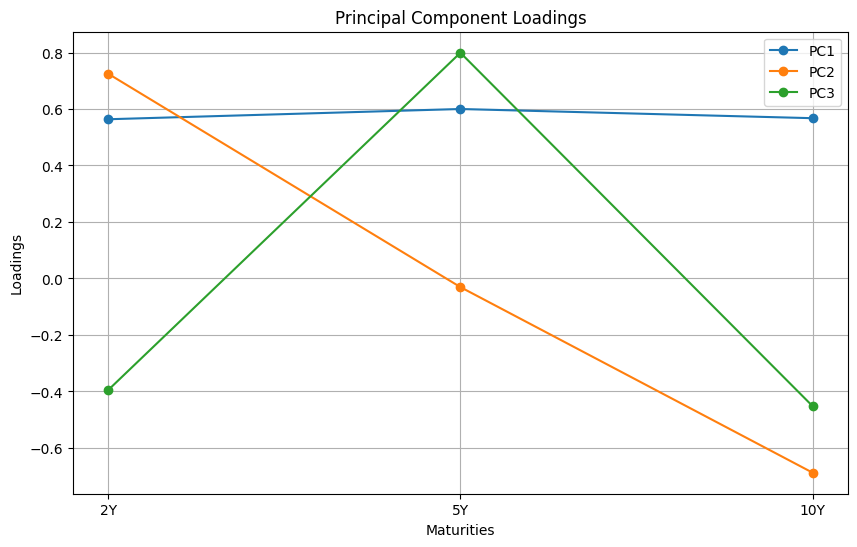

In [6]:
import numpy as np
from sklearn.decomposition import PCA


pca = PCA(n_components=3)
pca.fit(yields_diff_scaled)
explained_variance = pca.explained_variance_ratio_
components = pca.components_
for i, (var, comp) in enumerate(zip(explained_variance, components), start=1):
    print(f"Principal Component {i}:")
    print(f"  Explained Variance: {var:.4f}")
    print(f"  Loadings: {comp}")

labels = ['2Y','5Y','10Y']
x = np.arange(len(labels))
width = 0.25    

plt.figure(figsize=(10,6))
plt.plot(labels, components[0], marker='o', label='PC1')
plt.plot(labels, components[1], marker='o', label='PC2')
plt.plot(labels, components[2], marker='o', label='PC3')
plt.title('Principal Component Loadings')
plt.xlabel('Maturities')
plt.ylabel('Loadings')
plt.legend()
plt.grid()
plt.show()

#### - The first component explains 91% of the variance, the second component explains 8.1% of the variance, while the last component explains 0.8% of the variance

### c) Interpret each factor economically:
   - Which factor captures parallel shifts?  
        - The first principal component captures the parallel shift since the two bond yields move together
   - Which captures steepening/flattening?  
        - The second component captures steepening and flattening
   - Which captures curvature?  
        - The third component captures curvature

### d) Test loading stability: Re-run PCA on the first half and second half of your sample separately. Do the loadings change materially? What does this imply for using fixed weights over time?

*Note: Discussion 2.1 runs PCA on yield levels. Here you run PCA on yield changes—the standard approach for risk management. Comment on why this distinction matters.*

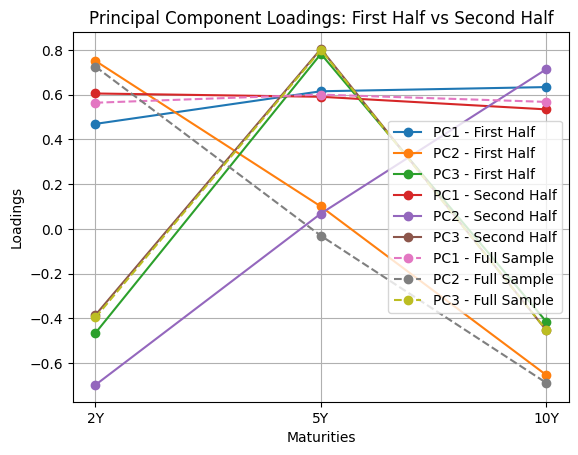

In [7]:
first_half_yield = yields_diff_scaled[:len(yields_diff_scaled)//2]
second_half_yield = yields_diff_scaled[len(yields_diff_scaled)//2:]

pca_first_half = PCA(n_components=3)
pca_first_half.fit(first_half_yield)
explained_variance_first_half = pca_first_half.explained_variance_ratio_
components_first_half = pca_first_half.components_
pca_second_half = PCA(n_components=3)
pca_second_half.fit(second_half_yield)
explained_variance_second_half = pca_second_half.explained_variance_ratio_
components_second_half = pca_second_half.components_

plt.Figure(figsize=(12,6))
plt.plot(labels, components_first_half[0], marker='o', label='PC1 - First Half')
plt.plot(labels, components_first_half[1], marker='o', label='PC2 - First Half')
plt.plot(labels, components_first_half[2], marker='o', label='PC3 - First Half')
plt.plot(labels, components_second_half[0], marker='o', label='PC1 - Second Half')
plt.plot(labels, components_second_half[1], marker='o', label='PC2 - Second Half')
plt.plot(labels, components_second_half[2], marker='o', label='PC3 - Second Half')
plt.plot(labels, components[0], marker='o', label='PC1 - Full Sample', linestyle='--')
plt.plot(labels, components[1], marker='o', label='PC2 - Full Sample', linestyle='--')
plt.plot(labels, components[2], marker='o', label='PC3 - Full Sample', linestyle='--')
plt.title('Principal Component Loadings: First Half vs Second Half')
plt.xlabel('Maturities')
plt.ylabel('Loadings')
plt.legend()
plt.grid()
plt.show()

#### 1. Do the loadings change materially?
Yes, the loadings show material changes over time.
- **PC1 (Level/Parallel Shift):** In the first half, PC1 loadings were approximately [0.47, 0.61, 0.63], showing higher sensitivity to the 10Y maturity. In the second half, they shifted to [0.61, 0.59, 0.53], becoming more sensitive to the 2Y maturity. This indicates that the "parallel" shift is not perfectly stable and its driver shifts between long and short ends.
- **PC2 (Slope/Tilt):** The slope factor also exhibits changes in its pivot point and magnitude, reflecting changing correlations between the short and long ends of the curve.

#### 2. What does this imply for using fixed weights over time?
The instability of factor loadings implies that **fixed hedge ratios or butterfly weights are not reliable for long-term risk management**.
- A trade constructed to be "PCA-neutral" based on historical data (e.g., 2015-2020) would likely have significant residual risk exposure if held through 2025.
- **Implication:** Effective risk management requires **dynamic rebalancing**. Weights should be updated periodically using a rolling window of historical data (e.g., a 6-month or 1-year rolling PCA) to adapt to the current market regime.